In [240]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm.notebook import trange

# clusetering 

## Define functions

In [80]:
import phase_utils as pu
from importlib import reload
from sklearn.cluster import KMeans

reload(pu)

def set_seed(seed):
    np.random.seed(seed)

# mapping label function
def mapping(row_names):
    # map
    key2lb = {"frs_m": "z",
              "chi": "\chi",
              "ac2p_1st": "A_1",
              "ac2p_large": "A_{large}",
              "tau_1st": "\\tau_1",
              "tau_large": "\\tau_{large}",
              "cc1p": "C",
              "leading_ratio": "\eta",
              "leading_ratio(abs)": "|\eta|",
              "dphi": "\Delta \phi"}
    
    labels = row_names.copy()
    key2lb_list = list(key2lb.keys())
    for n, key in enumerate(row_names):
        for km in key2lb_list:
            if key.find(km) > -1:
                if km == "leading_ratio" and key.find("abs") > -1:
                    continue
                
                labels[n] = labels[n].replace(km, key2lb[km])
                break
        
        if "_std" in key:
            labels[n] = labels[n].replace("_std", "")
            labels[n] = "\\sigma[%s]"%(labels[n])
            # labels[n] = labels[n]

        labels[n] = "$%s$"%(labels[n])

    return labels
        
    
def construct_square_image(prefix, data, col_names, ld=15):
    # data (-1, N)
    if ld is None:
        pass

    im = np.zeros([ld, ld])
    is_valid = False
    for n, cn in enumerate(col_names):
        if prefix in cn[0]:
            nr, nc = cn[1], cn[2]
            im[nr, nc] = data[:, n]
            is_valid = True
    
    if not is_valid:
        raise ValueError("%s does not exist in col_names"%(prefix))

    return im

In [81]:
# Load data
with open('./summary_data.pkl', "rb") as fp:
    post_data = pkl.load(fp)

print(post_data.keys())
print(post_data["summary_data"].keys())
print(post_data["summary_data_var"].keys())
print(post_data["summary_data"]["nr0np0"].keys())
print(post_data["summary_data_var"]["nr0np0"].keys())

dict_keys(['order', 'order_dyna', 'summary_data', 'summary_data_var', 'date'])
odict_keys(['nr0np0', 'nr0np1', 'nr0np2', 'nr0np3', 'nr0np4', 'nr0np5', 'nr0np6', 'nr1np0', 'nr1np1', 'nr1np2', 'nr1np3', 'nr1np4', 'nr1np5', 'nr1np6'])
odict_keys(['nr0np0', 'nr0np1', 'nr0np2', 'nr0np3', 'nr0np4', 'nr0np5', 'nr0np6', 'nr1np0', 'nr1np1', 'nr1np2', 'nr1np3', 'nr1np4', 'nr1np5', 'nr1np6'])
odict_keys(['frs_m', 'chi', 'cv', 'ac2p_1st', 'ac2p_large', '1/tau_1st', '1/tau_large', 'cc1p', 'leading_ratio', 'leading_ratio(abs)', 'dphi'])
odict_keys(['frs_m', 'chi', 'cv', 'ac2p_1st', 'ac2p_large', '1/tau_1st', '1/tau_large', 'cc1p', 'leading_ratio', 'leading_ratio(abs)', 'dphi'])


## Load data

skipped overlap key: leading_ratio_std
skipped overlap key: leading_ratio(abs)_std
datadim: (40, 3150), nrow: 40, ncol: 3150
correcting std names target keys ['1/tau_1st_std(0)', '1/tau_1st_std(1)', '1/tau_1st_std(2)', '1/tau_large_std(0)', '1/tau_large_std(1)', '1/tau_large_std(2)']


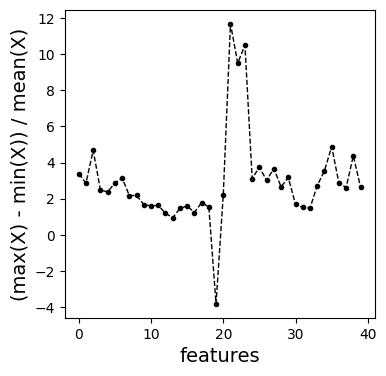

In [82]:
align_data, row_names, col_names = pu.concat_data(post_data, key_to_rm=["cv", "dphi"], include_std=True, show_mm_scale=True)
row_labels = mapping(row_names)

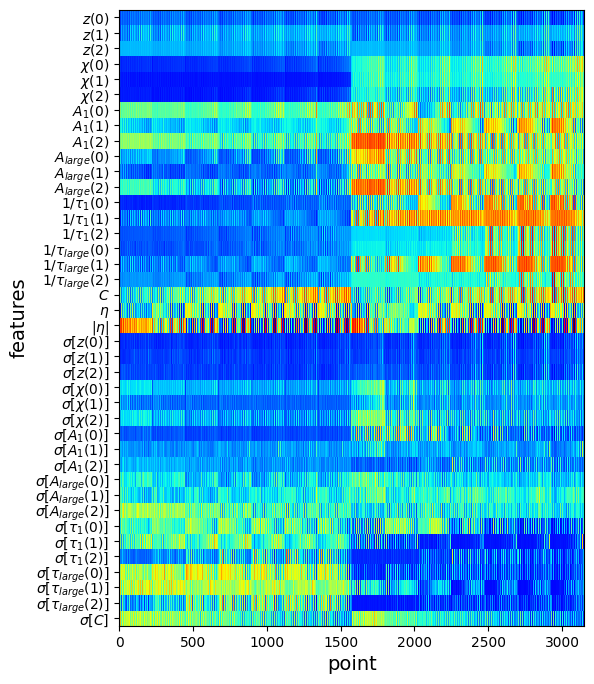

In [83]:
s_data = pu.hsmooth(align_data, wsize=10, fo=2)

plt.figure(figsize=(6, 8))
plt.imshow(s_data, aspect="auto", cmap="jet", interpolation="none")
plt.xlabel("point", fontsize=14)
plt.ylabel("features", fontsize=14)
plt.yticks(np.arange(0, len(row_names), 1), labels=row_labels[::1])
plt.show()

## K-means clustering with full rank data, explore K

In [6]:
## Quantization
set_seed(200)

num_clusters = np.arange(2, 24)
km_scores = []
s_scores = []
s_vals = []

align_data, row_names, col_names = pu.concat_data(post_data, key_to_rm=["cv", "dphi"], include_std=True, show_mm_scale=False)

km_obj_set = []
for nc in num_clusters:
    km_obj = KMeans(n_clusters=nc, init="k-means++", n_init="auto")
    km_obj.fit(align_data.T)
    labels = km_obj.predict(align_data.T)
    sval, scoeff = pu.get_silhouette_scores(align_data, labels)

    km_scores.append(km_obj.inertia_)
    s_scores.append(scoeff)
    s_vals.append(sval)

    km_obj_set.append(km_obj)

skipped overlap key: leading_ratio_std
skipped overlap key: leading_ratio(abs)_std
datadim: (40, 3150), nrow: 40, ncol: 3150
correcting std names target keys ['1/tau_1st_std(0)', '1/tau_1st_std(1)', '1/tau_1st_std(2)', '1/tau_large_std(0)', '1/tau_large_std(1)', '1/tau_large_std(2)']


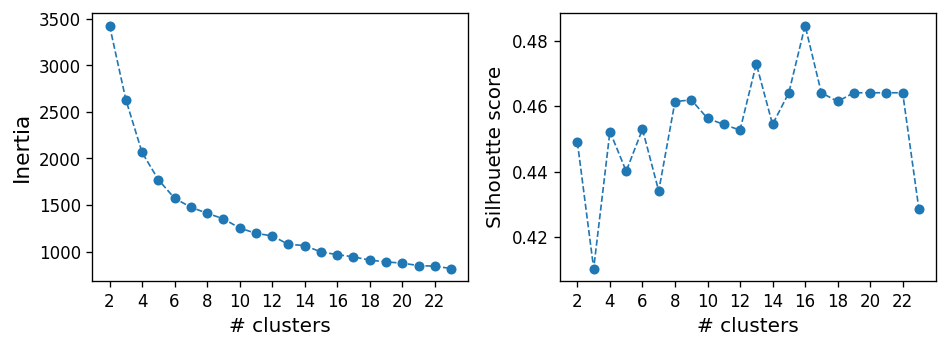

In [7]:
fig, axs = plt.subplots(1, 2, dpi=120, figsize=(8, 3))
plt.axes(axs[0])
plt.plot(num_clusters, km_scores, '.--', ms=10, lw=1)
plt.ylabel("Inertia", fontsize=13)
plt.xticks(num_clusters[::2])
plt.xlabel("# clusters", fontsize=12)

plt.axes(axs[1])
plt.plot(num_clusters, s_scores, '.--', ms=10, lw=1)
plt.ylabel("Silhouette score", fontsize=12)
plt.xticks(num_clusters[::2])
plt.xlabel("# clusters", fontsize=12)

plt.tight_layout()
plt.show()

11


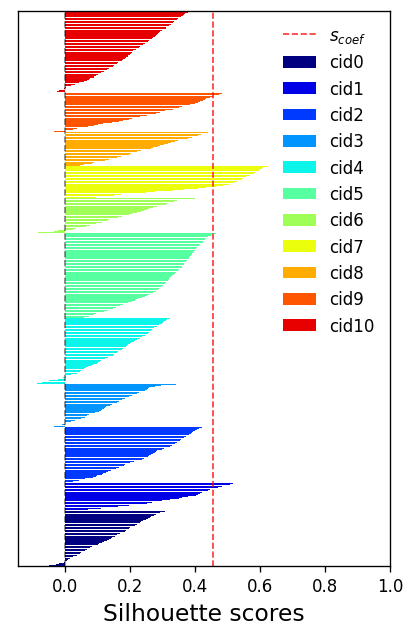

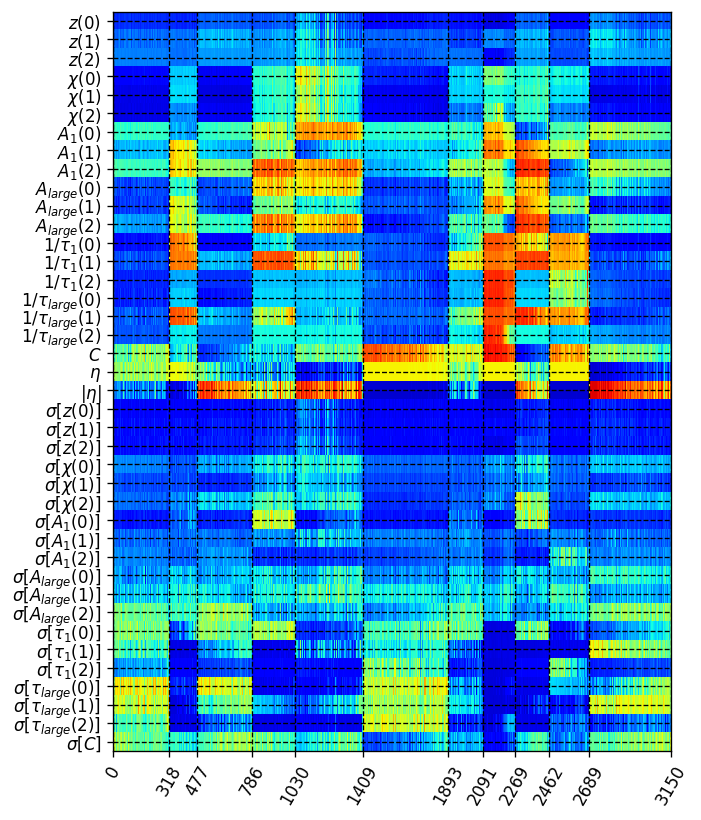

In [8]:
nc = 9
print(num_clusters[nc])
cluster_ids = km_obj_set[nc].predict(align_data.T)

reordered_data, id_sort, bds = pu.reorder_data(align_data, cluster_ids, s_vals[nc])

plt.figure(dpi=120, figsize=(4, 6))
pu.draw_silhouette(s_vals[nc], cluster_ids, scoeff=s_scores[nc])
plt.show()

# draw sval in ordered manner
s_data = pu.hsmooth(reordered_data)

plt.figure(figsize=(6, 8), dpi=120)
plt.imshow(s_data, aspect='auto', cmap="jet", interpolation="none")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_names)), labels=mapping(row_names))
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()

# tag = "nr1np5"
# # tag = "nr1np5"s
# alpha = s_vals[nc]
# alpha = (alpha - np.min(alpha)) / (np.max(alpha) - np.min(alpha))

# im = construct_square_image(tag, cluster_ids[np.newaxis, :], col_names)
# # alpha = construct_square_image(tag, alpha[np.newaxis, :], col_names)

In [45]:
# check variation for each clusters
f_std = []
for nc in trange(len(num_clusters)):
    cluster_ids = km_obj_set[nc].predict(align_data.T)
    reordered_data, _, bds = pu.reorder_data(align_data, cluster_ids)
    # align data
    data_avg = []
    bds = [0] + bds
    for nbd in range(len(bds)-1):
        data_avg.append(np.average(reordered_data[:, bds[nbd]:bds[nbd+1]], axis=1))
    data_avg = np.array(data_avg).T
    
    f_std.append(np.std(data_avg, axis=1))

fs_avg = np.average(f_std, axis=0)
fs_std = np.std(f_std, axis=0)

  0%|          | 0/22 [00:00<?, ?it/s]

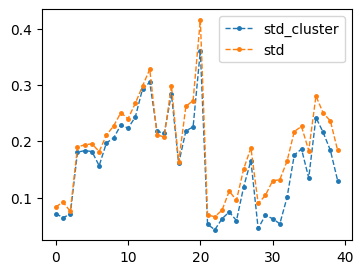

In [54]:
plt.figure(dpi=100, figsize=(4, 3))
plt.plot(fs_avg, '.--', ms=5, lw=1, label="std_cluster")
plt.plot(np.std(reordered_data, axis=1), '.--', ms=5, lw=1, label="std")
plt.legend()
plt.show()

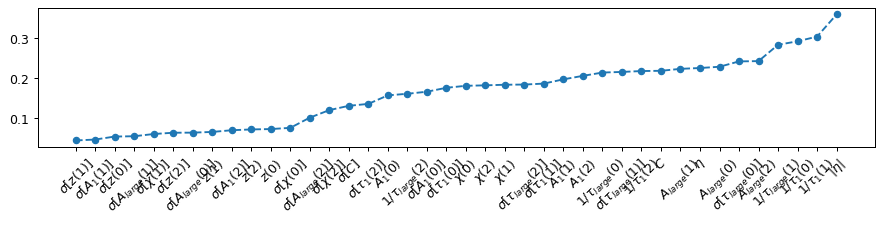

In [55]:
# rank variation for each vars
sort_ind = np.argsort(fs_avg)

sort_labels = [row_labels[n] for n in sort_ind]
sort_fs = np.array([fs_avg[n] for n in sort_ind])

x = np.arange(len(sort_f_std))
plt.figure(figsize=(12, 2), dpi=90)
plt.plot(x, sort_fs, '.--', ms=10)
plt.xticks(x, labels=sort_labels, rotation=45)
plt.show()

## Use purified data

skipped overlap key: leading_ratio_std
skipped overlap key: leading_ratio(abs)_std
datadim: (34, 3150), nrow: 34, ncol: 3150
correcting std names target keys ['1/tau_1st_std(0)', '1/tau_1st_std(1)', '1/tau_1st_std(2)', '1/tau_large_std(0)', '1/tau_large_std(1)', '1/tau_large_std(2)']
Purify more...
ac2p_large_std(1)
ac2p_large_std(0)
ac2p_1st_std(2)
ac2p_1st_std(1)
chi_std(1)
chi_std(0)


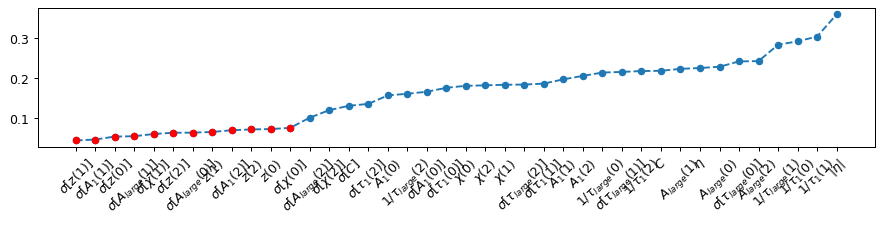

In [84]:
align_data_p, row_names_p, col_names_p = pu.concat_data(post_data, key_to_rm=["frs_m", "cv", "dphi"], include_std=True)

# remove std data
print("Purify more...")
nid_set = np.sort([18, 19, 22, 23, 24, 25])[::-1]
for nid in nid_set:
    print(row_names_p[nid])
    align_data_p = np.delete(align_data_p, nid, 0)
    del(row_names_p[nid])

row_labels_p = mapping(row_names_p)

# check removed labels
rids = []
for n, lb in enumerate(sort_labels):
    if lb not in row_labels_p:
        rids.append(n)

x = np.arange(len(sort_f_std))
plt.figure(figsize=(12, 2), dpi=90)
plt.plot(x, sort_fs, '.--', ms=10)
plt.plot(x[rids], sort_fs[rids], 'r.', ms=10)
plt.xticks(x, labels=sort_labels, rotation=45)
plt.show()

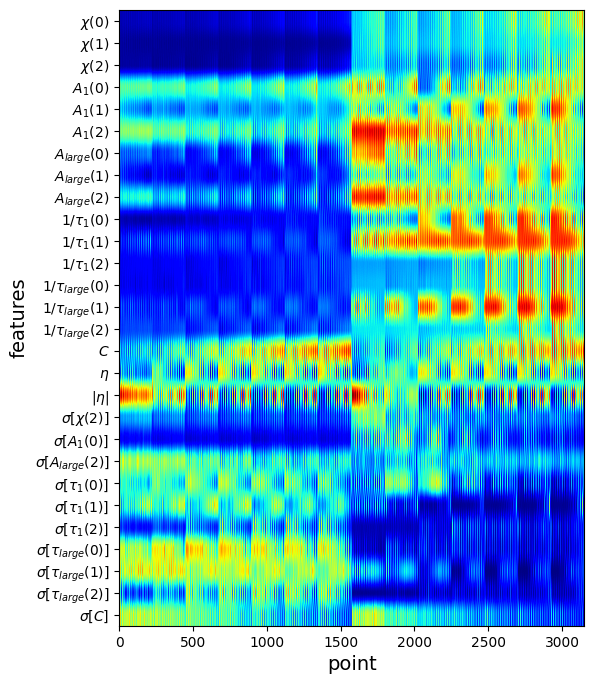

In [85]:
plt.figure(figsize=(6, 8))
plt.imshow(align_data_p, aspect="auto", cmap="jet")
plt.xlabel("point", fontsize=14)
plt.ylabel("features", fontsize=14)
plt.yticks(np.arange(0, len(row_names_p), 1), labels=row_labels_p[::1])
plt.show()

### Save purified data

In [89]:
with open("./data/purified_data.pkl", "wb") as fp:
    pkl.dump({"data": align_data_p,
              "row_labels": row_labels_p,
              "row_names": row_names_p,
              "col_names": col_names_p}, fp)

### K-means clustering, test

In [86]:
set_seed(200)

num_c = 9

km_obj = KMeans(n_clusters=num_c, init="k-means++", n_init="auto")
km_obj.fit(align_data_p.T)
cluster_id_p = km_obj.predict(align_data_p.T)

sval_p, scoeff_p = pu.get_silhouette_scores(align_data_p, cluster_id_p)
reordered_data, id_sort, bds = pu.reorder_data(align_data_p, cluster_id_p, sval_p)

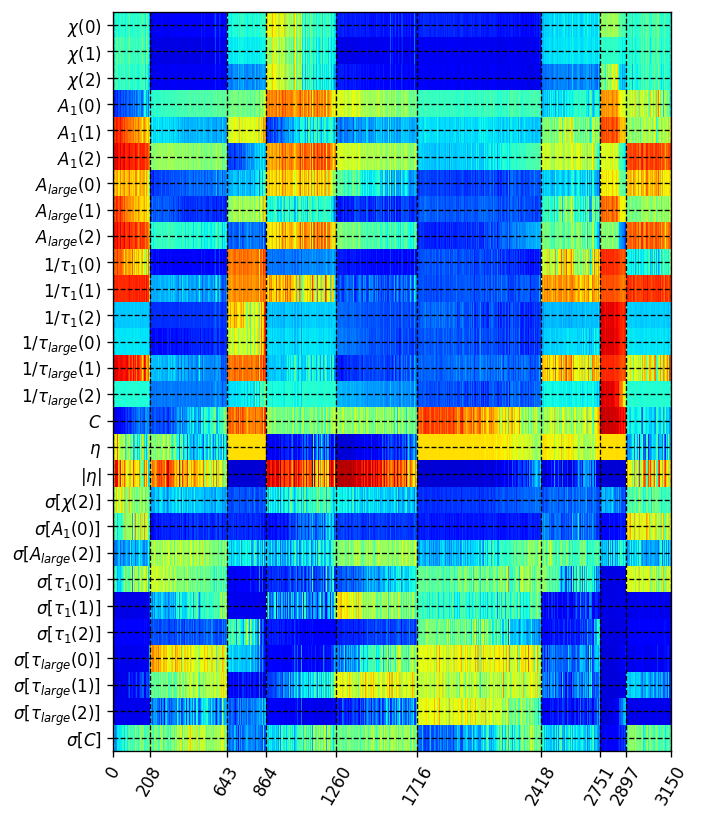

In [87]:
sdata = pu.hsmooth(reordered_data)

plt.figure(figsize=(6, 8), dpi=120)
plt.imshow(sdata, aspect='auto', cmap="jet", interpolation="none")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_names_p)), labels=mapping(row_names_p))
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()

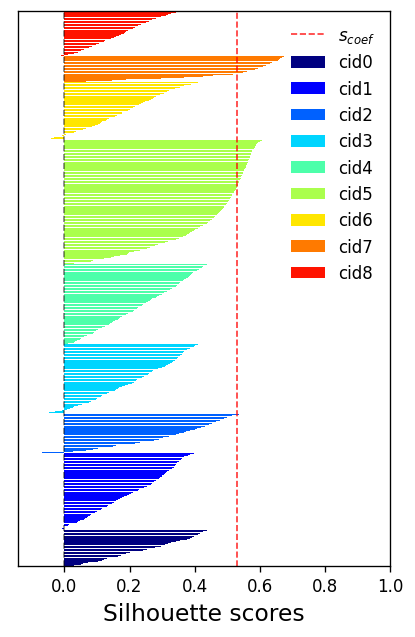

In [88]:
plt.figure(dpi=120, figsize=(4, 6))
pu.draw_silhouette(sval_p, cluster_id_p, scoeff=scoeff_p)
plt.show()

# K-means clustering with purified data

In [90]:
# load data
with open("./data/purified_data.pkl", "rb") as fp:
    buf = pkl.load(fp)
data = buf["data"]
row_labels = buf["row_labels"]
row_names = buf["row_names"]
col_names = buf["col_names"]

In [100]:
# Clustering
set_seed(500)

num_clusters = np.arange(2, 15)

km_scores = []
s_scores = []
s_vals = []
km_obj_set = []

for nc in num_clusters:
    km_obj = KMeans(n_clusters=nc, init="k-means++", n_init="auto")
    km_obj.fit(data.T)
    labels = km_obj.predict(data.T)
    sval, scoeff = pu.get_silhouette_scores(data, labels)

    km_scores.append(km_obj.inertia_)
    s_scores.append(scoeff)
    s_vals.append(sval)
    km_obj_set.append(km_obj)

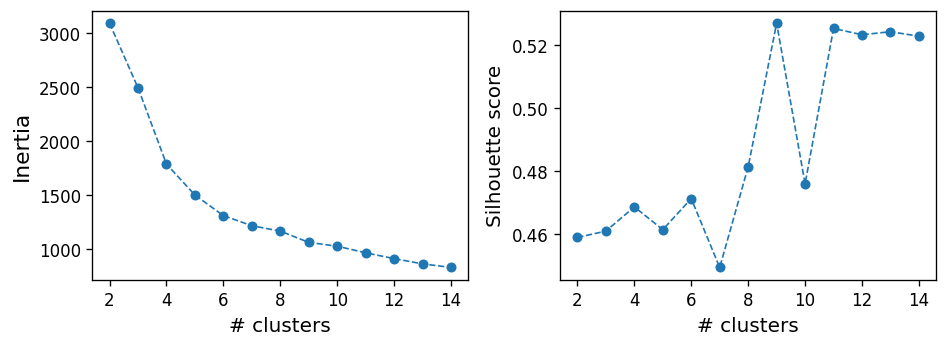

In [101]:
fig, axs = plt.subplots(1, 2, dpi=120, figsize=(8, 3))
plt.axes(axs[0])
plt.plot(num_clusters, km_scores, '.--', ms=10, lw=1)
plt.ylabel("Inertia", fontsize=13)
plt.xticks(num_clusters[::2])
plt.xlabel("# clusters", fontsize=12)

plt.axes(axs[1])
plt.plot(num_clusters, s_scores, '.--', ms=10, lw=1)
plt.ylabel("Silhouette score", fontsize=12)
plt.xticks(num_clusters[::2])
plt.xlabel("# clusters", fontsize=12)

plt.tight_layout()
plt.show()

In [122]:
import datetime

In [136]:
from datetime import datetime

In [138]:
from datetime import datetime
now = datetime.now()

In [139]:
now

datetime.datetime(2023, 6, 21, 1, 45, 29, 412887)

In [141]:
now.year

2023

In [142]:
def save_fig(fig_name, fdir="./data"):
    # figname: don't type expander
    from datetime import datetime
    import os
    
    now = datetime.now()
    
    fname = os.path.join(fdir, fig_name)
    fname = fname + "_%d%d%d.png"%(now.year, now.month, now.day)
    print("save to %s"%fname)
    plt.savefig(fname)

num_clusters: 11
save to ./data/filtered_cluster_nc=11_2023621.png


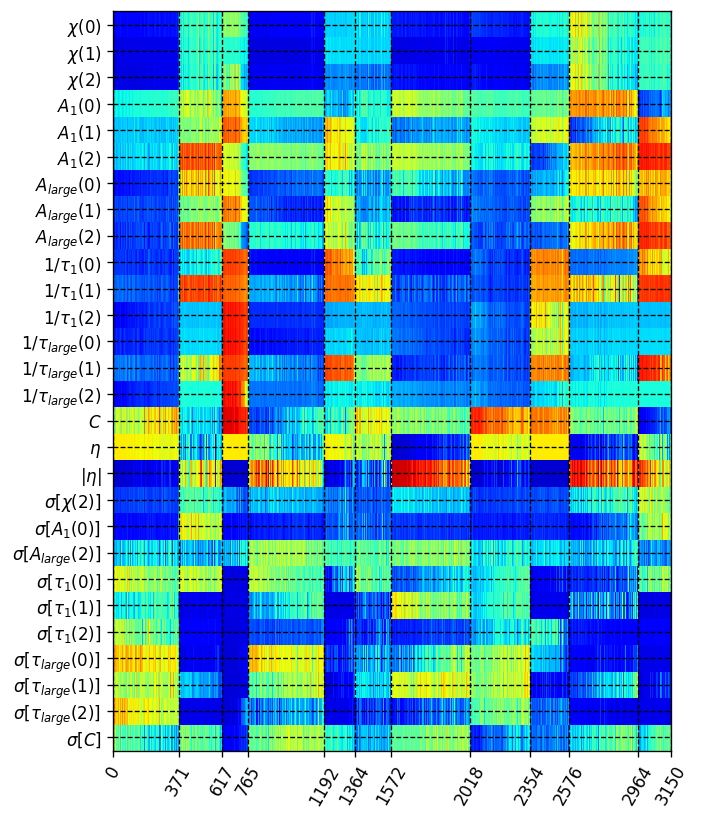

In [146]:
nc = 9
num_c = num_clusters[nc]

print("num_clusters: %d"%(num_c))

cluster_id = km_obj_set[nc].predict(data.T)
sval = s_vals[nc]
scoeff = s_scores[nc]

reordered_data, id_sort, bds = pu.reorder_data(data, cluster_id, sval)
sdata = pu.hsmooth(reordered_data)

plt.figure(figsize=(6, 8), dpi=120)
plt.imshow(sdata, aspect='auto', cmap="jet", interpolation="none")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_names_p)), labels=mapping(row_names_p))
plt.grid(True, lw=0.8, c='k', linestyle='--')
save_fig("filtered_cluster_nc=%d"%(num_clusters[nc]))

plt.show()

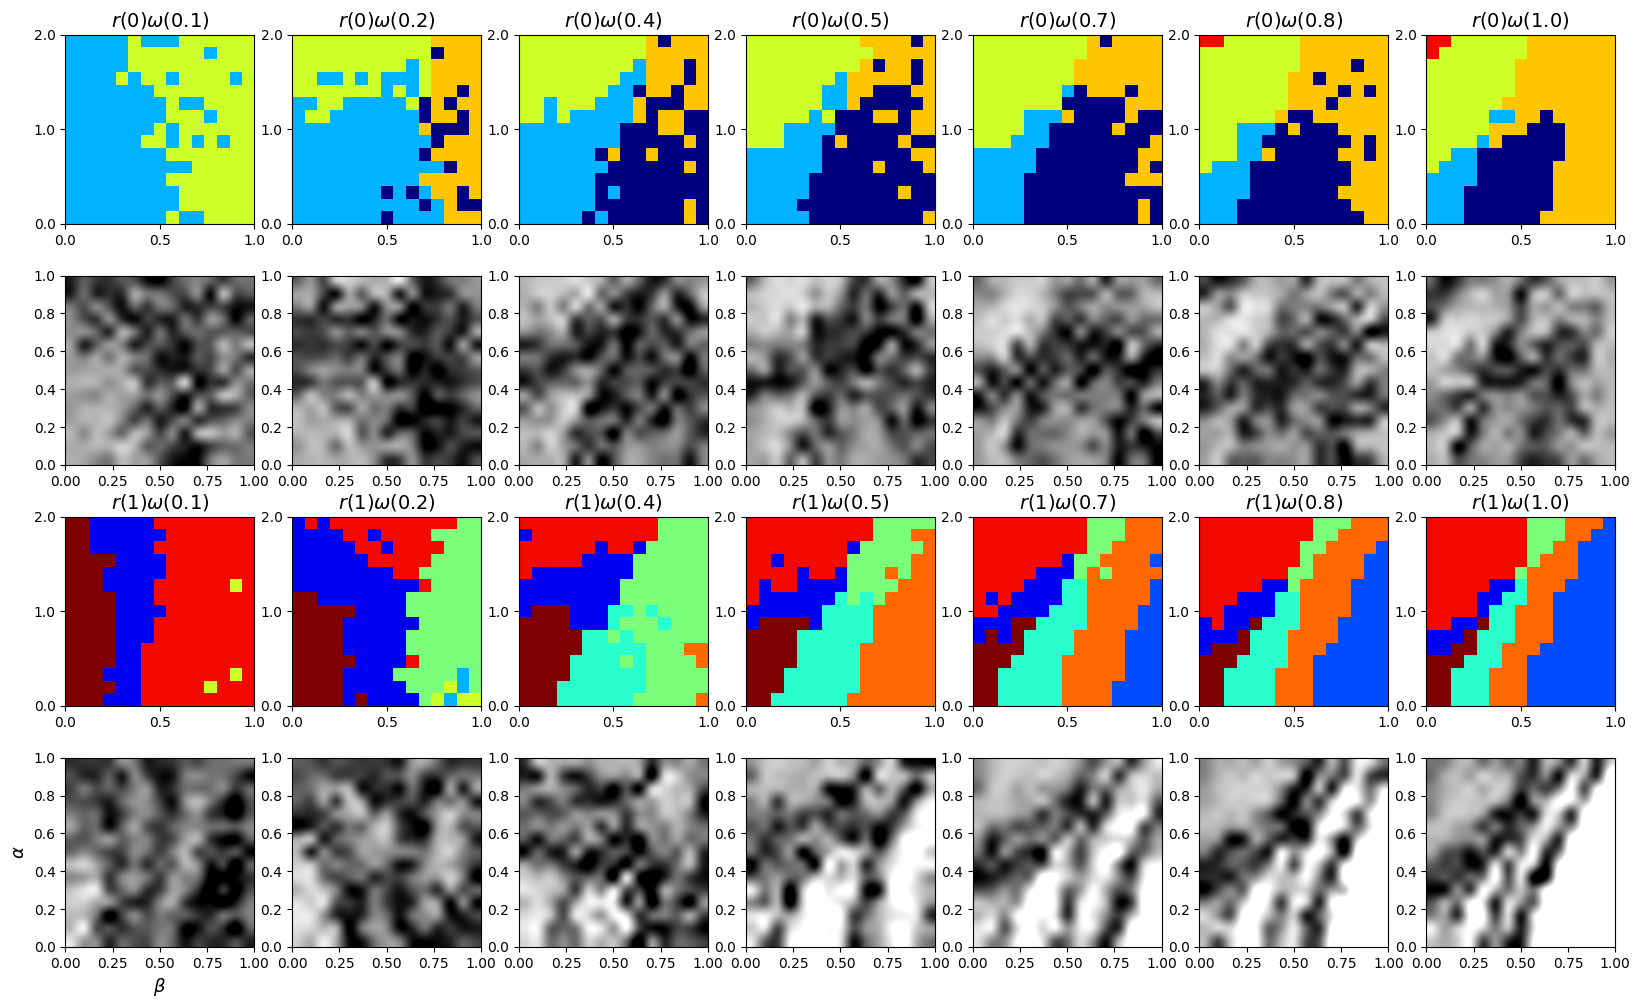

In [165]:
w = np.arange(0.1, 1.01, 0.15)
im_stacks = []

plt.figure(dpi=100, figsize=(20, 12))
for nr in range(2):
    for nw in range(7):

        im = construct_square_image("nr%dnp%d"%(nr, nw), cluster_id[np.newaxis, :], col_names)
        im_sval = construct_square_image("nr%dnp%d"%(nr, nw), sval[np.newaxis, :], col_names)
        cmap = plt.get_cmap("jet", num_c)
        
        plt.subplot(4, 7, nr*7*2+nw+1)
        cax = plt.imshow(im, vmin=0, vmax=np.max(cluster_id), origin="lower", extent=[0, 1, 0, 1], cmap=cmap)
        plt.title(r"$r(%d)\omega(%.1f)$"%(nr, w[nw]), fontsize=14)
        plt.xticks([0, 0.5, 1])
        plt.yticks([0, 0.5, 1], labels=["0.0", "1.0", "2.0"])
        
        plt.subplot(4, 7, nr*7*2+nw+8)
        cax = plt.imshow(im_sval, vmin=0, vmax=0.5, origin="lower", extent=[0, 1, 0, 1], cmap="gray", interpolation="spline16")
        
        im_stacks.append(im)

        if nr == 1 and nw == 0:
            plt.xlabel(r"$\beta$", fontsize=13)
            plt.ylabel(r"$\alpha$", fontsize=13)

plt.show()

In [ ]:
# denoise image
def denoise_square_cluster(sq_cluster_id):
    sq_cluster_id = np.array(sq_cluster_id).copy()
    nr = sq_cluster_id.shape[0]
    nc = sq_cluster_id.shape[1]
    
    dirs = ((1, 0), (-1, 0), (0, 1), (0, -1))
    cmax = int(np.max(sq_cluster_id))
    
    for i in range(nr):
        for j in range(nc):
            cid = sq_cluster_id[i, j]
            cid_exist = np.zeros(cmax+1)
            flag_r = True
            
            for d in dirs:
                i1 = i + d[0]
                j1 = j + d[1]
                if (i1<0) or (i1>nr-1) or (j1<0) or (j1>nc-1):
                    continue
                    
                cid_nn = sq_cluster_id[i1, j1]
                if cid == cid_nn:
                    flag_r = False
                    break
                
                cid_exist[int(cid_nn)] += 1
            
            # alter the cluster_id
            if flag_r:
                sq_cluster_id[i, j] = np.argmax(cid_exist)
            
    return sq_cluster_id


def gather_clusters(sq_cluster_id):
    nrow, ncol = sq_cluster_id.shape
    
    cluster_island = []
    cid = -1
    for nr in range(nrow):
        for nc in range(ncol):
            if sq_cluster_id[nr, nc] != cid:
                cluster_island.append([])
                cid = sq_cluster_id[nr, nc]
            cluster_island[-1].append((nr, nc))
            
    return cluster_island


def remove_cluster_island(sq_cluster_id_, nth=3):
    dirs = ((-1, 0), (1, 0), (0, -1), (0, 1))
    sq_cluster_id = sq_cluster_id_.copy()
    nrow, ncol = sq_cluster_id.shape
    cluster_island = gather_clusters(sq_cluster_id)
    for n in range(len(cluster_island)):
        if len(cluster_island[n]) < nth:
            cid = -1
            flag_flip = True
            for nr, nc in cluster_island[n]:
                # get n.n
                for d in dirs:
                    if not((nr+d[0] > 0) and (nr+d[0] < nrow) and (nc+d[1] > 0) and (nc+d[1] < ncol)):
                        continue
                        
                    cid_tmp = sq_cluster_id[nr+d[0], nc+d[1]]
                    if cid == -1:
                        cid = cid_tmp
                    elif cid != cid_tmp:
                        flag_flip = False
                        break
            
            if flag_flip:
                for nr, nc in cluster_island[n]:
                    sq_cluster_id[nr, nc] = cid
                    
    return sq_cluster_id

In [262]:
tag = "nr1np5"

im0 = construct_square_image(tag, cluster_id[np.newaxis, :], col_names)
im1 = denoise_square_cluster(im0)
im1 = remove_cluster_island(im1, nth=3)

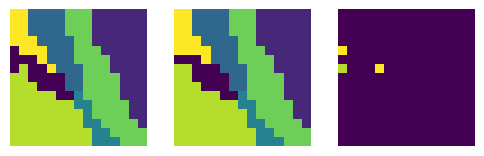

In [263]:
plt.figure(figsize=(6, 3))
plt.subplot(131)
plt.imshow(im0)
plt.axis("off")

plt.subplot(132)
plt.imshow(im1)
plt.axis("off")

plt.subplot(133)
plt.imshow(np.abs(im1 - im0))
plt.axis("off")

plt.show()

### Denoise & Realign cluster id 

In [199]:
# realign cluster id
cluster_id = np.array(cluster_id, dtype=int).copy()

for nr in range(2):
    for nw in range(7):
        im = construct_square_image("nr%dnp%d"%(nr, nw), cluster_id[np.newaxis, :], col_names)
        im_d = denoise_square_cluster(im)
        
        
        break
    break

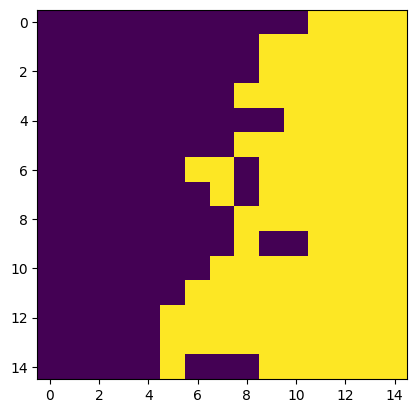

In [200]:
plt.imshow(im_d)

# Test with simulation data

In [117]:
def get_gaussian_mix_samples(num_points, num_c, sgm_s=0.1, sgm_d=0.1, mu_low=0, mu_high=1):
    def inv_sigmoid(values):
        return np.log(values/(1-values))

    avgs = np.random.uniform(low=mu_low, high=mu_high, size=(num_c, 2))
    covs = np.zeros([num_c, 2, 2])
    for i in range(num_c):
        covs[i, 0, 0] = sgm_s
        covs[i, 1, 1] = sgm_s
        covs[i, 0, 1] = np.random.randn() * sgm_d
        covs[i, 1, 0] = covs[i, 0, 1] 

    # eigs
    eval, evec = np.zeros([num_c, 2, 2]), np.zeros([num_c, 2, 2])
    for i in range(num_c):
        eval[i, :, :], evec[i, :, :] = np.linalg.eig(covs[i, :, :])

    # get sample points
    num_points = int(num_points)
    pdata = np.zeros([num_points, 2])
    plabels = np.zeros(num_points)

    dim = 2
    for n in range(num_points):
        r = np.random.uniform()
        # equal sampling
        nid = int(r / (1 / num_c))

        ytmp = np.random.uniform(0, 1, size=(dim, 3))
        xnorm = np.mean(inv_sigmoid(ytmp), axis=1).reshape((-1, dim))
        pts = (xnorm * eval[nid]) @ evec[nid] + avgs[nid]
        pdata[n] = pts[0]
        plabels[n] = nid

    return pdata, plabels, avgs

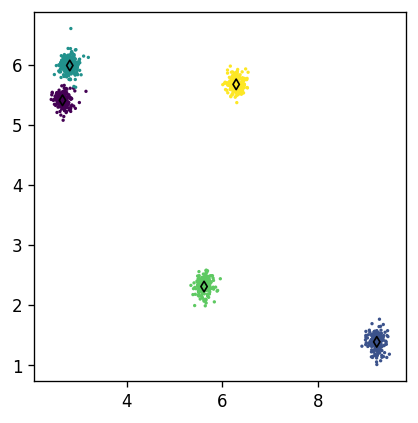

In [125]:
pdata, plabels, pcent = get_gaussian_mix_samples(1e3, 5, sgm_s=0.1, sgm_d=0., mu_high=10, mu_low=0)

plt.figure(figsize=(4, 4), dpi=120)
plt.scatter(pdata[:, 0], pdata[:, 1], c=plabels, s=1)
plt.scatter(pcent[:, 0], pcent[:, 1], c=np.arange(pcent.shape[0]), s=20, marker="d", edgecolor="k")
plt.show()

In [196]:
from sklearn.cluster import KMeans

def compare_cluster_result(X, kmean_obj: KMeans, label_x=None, cent_x=None):
    num_k = len(kmean_obj.cluster_centers_)

    plt.figure(dpi=120, figsize=(8, 4.5))
    # data
    plt.subplot(121)
    if label_x is None:
        label_x = np.zeros(len(X))
    
    plt.scatter(X[:, 0], X[:, 1], c=label_x, s=1)
    if cent_x is not None:
        plt.scatter(cent_x[:, 0], cent_x[:, 1], c=np.arange(len(cent_x)), s=30, marker="d", edgecolor="k")
    plt.title("data", fontsize=13)

    # pred
    plt.subplot(122)
    label_pred = kmean_obj.predict(X)
    cc = kmean_obj.cluster_centers_
    plt.scatter(X[:, 0], X[:, 1], c=label_pred, s=1)
    plt.scatter(cc[:, 0], cc[:, 1], s=100, marker="x", c="k", label="pred")
    if cent_x is not None:
        plt.scatter(cent_x[:, 0], cent_x[:, 1], c=np.arange(len(cent_x)), s=30, marker="d", edgecolor="r", label="real")
    plt.legend(fontsize=13)
    plt.title("predicted", fontsize=13)

    num_c = -1 if label_x is None else len(np.unique(label_x))

    plt.suptitle("K-means clustering with %d clusters (real: %d)"%(len(cc), num_c))

    plt.tight_layout()
    plt.show()

In [201]:
pdata, plabels, pcent = get_gaussian_mix_samples(1e3, 4, sgm_s=0.5, sgm_d=0.1, mu_high=10, mu_low=0)

Kmean = KMeans(n_clusters=6, init="k-means++", n_init="auto")
Kmean.fit(pdata)
pred_labels = Kmean.predict(pdata)

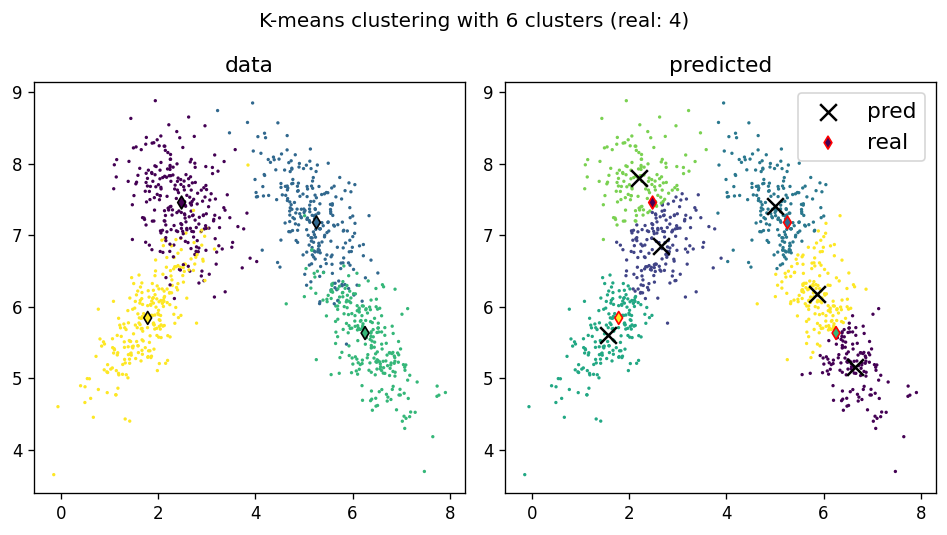

In [202]:
compare_cluster_result(pdata, Kmean, label_x=plabels, cent_x=pcent)

# Simulation data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../include/")
import hhclusters

from importlib import reload
reload(hhclusters)

import pickle as pkl
with open('./summary_data.pkl', "rb") as fp:
    post_data = pkl.load(fp)

SyntaxError: invalid syntax (hhclusters.py, line 183)

In [1]:
align_data, row_names, col_names = hhclusters.concat_data(post_data, key_to_rm=["cv", "dphi"])

NameError: name 'hhclusters' is not defined

In [23]:
cluster_ids, km_obj = hhclusters.kmeans_clustering(align_data, n_clusters=12)
sh_score, sh_coef = hhclusters.get_silhouette_scores(align_data, cluster_ids)

In [31]:
from tqdm.notebook import tqdm

cluster_ids, km_objs, sh_scores, sh_coefs = [], [], [], []
num_clusters = np.arange(2, 25)
for nc in tqdm(num_clusters):
    cid, km_obj = hhclusters.kmeans_clustering(align_data, nc)
    sh_score, sh_coef = hhclusters.get_silhouette_scores(align_data, cid)
    cluster_ids.append(cid)
    km_objs.append(km_obj)
    sh_scores.append(sh_score)
    sh_coefs.append(sh_coef)

  0%|          | 0/23 [00:00<?, ?it/s]

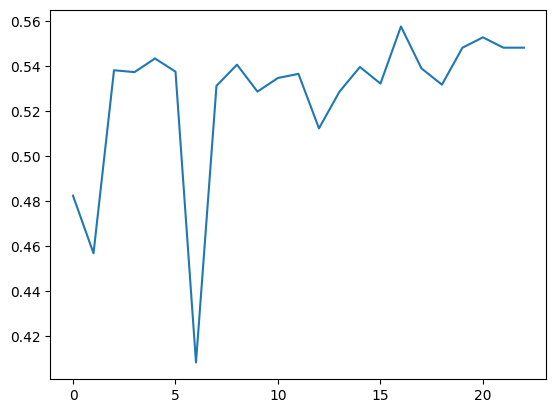

In [28]:
plt.figure()
plt.plot(sh_coefs)

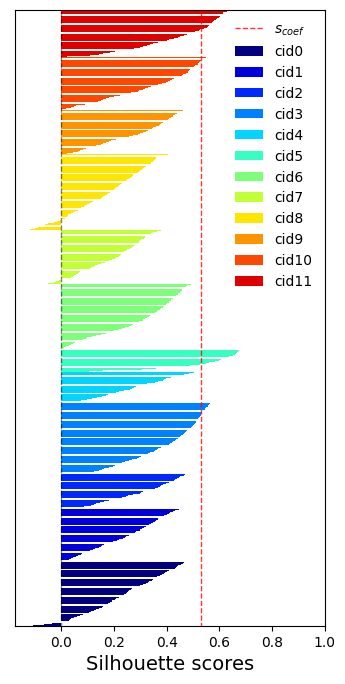

In [24]:
plt.figure(figsize=(4, 8))
hhclusters.draw_silhouette(sh_score, cluster_ids, sh_coef)
plt.show()

In [29]:
r_data, r_inds, bds = hhclusters.reorder_data(align_data, id_cluster=cluster_ids, sval=sh_score)

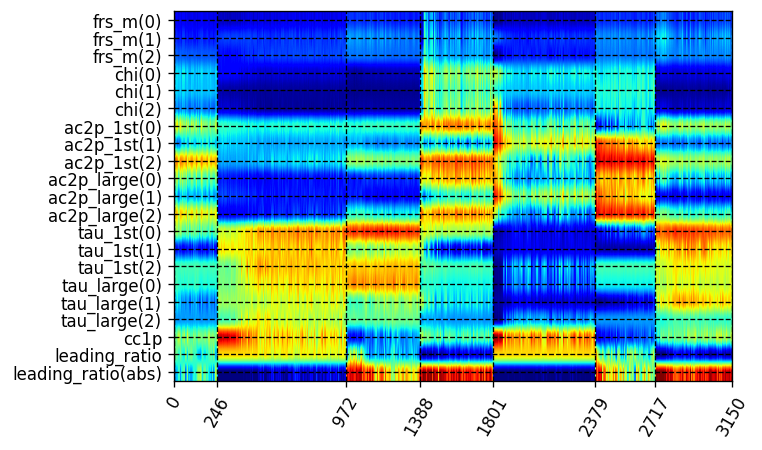

In [30]:
# draw sval in ordered manner
plt.figure(figsize=(6, 4), dpi=120)
plt.imshow(r_data, aspect='auto', cmap="jet")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_names)), labels=row_names)
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()